In [ ]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

print(pytesseract.image_to_string('./image2.png', lang='eng'))

# OpenCV OCR 및 Tesseract text 인식 이해
1. input Image
2. OpenCV EAST Text Detector
- 이미지의 텍스트 존재를 감지
- 텍스트 ROI의 바운딩 박스(x,y)좌표를 제공
3. Extract TExt ROIs
4. Tesseract v4 OCR with LSTM
5. OpenCV + Tesseract Results

## tesseract flag
- -l : 입력 텍스트 언어 제어
- --oem : 알고리즘 유형 제어
- --psm : 자동 페이지 분할 모드

In [19]:
from imutils.object_detection import non_max_suppression
import numpy as np
import pytesseract
import argparse
import cv2

In [20]:
def decode_predictions(scores, geomery):
    
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    # 점수로 상자 box area 도출
    for y in range(0,numRows):
        scoresData = scores[0,0,y]
        xData0 = geometry[0,0,y]
        xData1 = geometry[0,1,y]
        xData2 = geometry[0,2,y]
        xData3 = geometry[0,3,y]
        anglesData= geometry[0,4,y]
        
        for x in range(0, numCols):
            # 점수가 낮으면 무시
            if scoresData[x] < args["min_confidence"]:
                continue
            # maps 는 입력 이미지보다 4배 더 작음
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            # 예상 회전 각도 추출
            # sin과 cos 계산
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            # 상자의 너비와 높이 유도
            h = xData0[x]  + xData2[x]
            w = xData1[x]  + xData3[x]
            
            # x,y좌표 뽑
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            
            # 경계상자의 확률 점수 추가
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    return  (rects, confidences)           

In [21]:
import easydict

args = easydict.EasyDict({
    "image" : '',
    "east" : '',
    "min_confidence" : 0.5,
    "width" : 320,
    "height" : 320,
    "padding": 0
    
})

In [22]:
args["image"] = './image2.PNG'

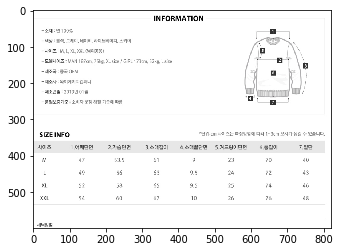

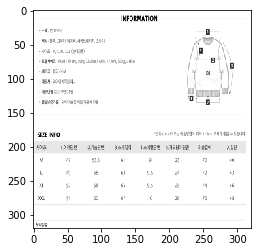

In [39]:
import matplotlib.pyplot as plt
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(origH, origW) = image.shape[:2]
 
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = origW / float(newW)
rH = origH / float(newH)
plt.imshow(image)
plt.show()
# image size를 지정해둔 사이즈(320, 320)로 축소 시킴
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]
plt.imshow(image)
plt.show()

In [24]:
args["east"] = './frozen_east_text_detection.pb'

In [40]:
layerNames = [ "feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
 
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
# EAST model load
net = cv2.dnn.readNet(args["east"])

[INFO] loading EAST text detector...


In [54]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
# 조명변화 방지위한 평균빼기
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),(123.68, 116.78, 103.94), swapRB=True, crop=False)
print(blob.shape)
net.setInput(blob)
# scores : 텍스트를 포함하는 주어진 영역의 확률
# geometry : 입력 이미지에서 텍스트의 경계 상자 좌표를 유도하는데 사용되는 출력
(scores, geometry) = net.forward(layerNames)
print(scores.shape, geometry.shape)
# decode the predictions, then  apply non-maxima suppression to
# suppress weak, overlapping bounding boxes
# rects : 텍스트 지역에 대한 경계 상자(X,Y)
# confidences : 각 경계 상자와 관련된 확률
(rects, confidences) = decode_predictions(scores, geometry)
print(len(rects), len(confidences))
boxes = non_max_suppression(np.array(rects), probs=confidences)
# 28개의 test boxes 검출
print(boxes.shape)

(1, 3, 320, 320)
(1, 1, 80, 80) (1, 5, 80, 80)
219 219
(28, 4)


In [63]:
# initialize the list of results
results = []
 
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)
 
	# in order to obtain a better OCR of the text we can potentially
	# apply a bit of padding surrounding the bounding box -- here we
	# are computing the deltas in both the x and y directions
	dX = int((endX - startX) * args["padding"])
	dY = int((endY - startY) * args["padding"])
 
	# apply padding to each side of the bounding box, respectively
	startX = max(0, startX - dX)
	startY = max(0, startY - dY)
	endX = min(origW, endX + (dX * 2))
	endY = min(origH, endY + (dY * 2))
 
	# extract the actual padded ROI
	roi = orig[startY:endY, startX:endX]
	# in order to apply Tesseract v4 to OCR text we must supply
	# (1) a language, (2) an OEM flag of 4, indicating that the we
	# wish to use the LSTM neural net model for OCR, and finally
	# (3) an OEM value, in this case, 7 which implies that we are
	# treating the ROI as a single line of text
	config = ("-l eng --oem 1 --psm 7")
	text = pytesseract.image_to_string(roi, config=config)
 
	# add the bounding box coordinates and OCR'd text to the list
	# of results
	results.append(((startX, startY, endX, endY), text))

In [64]:
# sort the results bounding box coordinates from top to bottom
results = sorted(results, key=lambda r:r[0][1])
 
# loop over the results
for ((startX, startY, endX, endY), text) in results:
	# display the text OCR'd by Tesseract
	print("OCR TEXT")
	print("========")
	print("{}\n".format(text))
 
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV, then draw the text and a bounding box surrounding
	# the text region of the input image
	text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
	output = orig.copy()
	cv2.rectangle(output, (startX, startY), (endX, endY),
		(0, 0, 255), 2)
	cv2.putText(output, text, (startX, startY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
 
	# show the output image
	cv2.imshow("Text Detection", output)
	cv2.waitKey(0)

OCR TEXT
NFORMATION

OCR TEXT
orton

OCR TEXT
Mt aro!

OCR TEXT
m Zo! tole

OCR TEXT
200.

OCR TEXT
cok:

OCR TEXT
t87om 75k X. size /

OCR TEXT
17300, Stig, L

OCR TEXT
- ewois

OCR TEXT
s2 oon

OCR TEXT
uses

OCR TEXT
sootoivem

OCR TEXT
nus

OCR TEXT
roroworg

OCR TEXT


OCR TEXT
cantor mel 1-3

OCR TEXT
en oa) ay a

OCR TEXT
"hem A

OCR TEXT
a

OCR TEXT
<i7E INED

OCR TEXT
s

OCR TEXT
1 oimitiot

OCR TEXT
a

OCR TEXT
640

OCR TEXT
Alok:

OCR TEXT
a atid)

OCR TEXT
2 ratio

OCR TEXT
535



In [1]:
results

NameError: name 'results' is not defined